#Introduction

The goal of the project is to predict the standard fantasy points* a player will earn in a given game against a given team. After training and testing, the model can predict a player's points within a 10 point range with ~52%. This is not a great prediction accuracy but, it is expected due to the randomness of the problem. In the final section of this report I will elaborate more on the randomness why it limits the predictive ability of my neural network. 

*See [Fantasy Football Scoring](https://www.rookieroad.com/football/fantasy/scoring-types-and-formats/) for more information of the types of scoring

# The Data
This sections includes my reasoning for the choice of data used to train the neural network, as well as how I compiled the data. There is an overwhemlimg ammount of data for NFL players and I wanted to ensure that I selected the best data that would help my neural network learn quickly and accurately. 

The raw data was manipulated in excel and then compiled into a single csv file for the model to read. Weekly player data was gathered from [Fantasy Football Data Pros](https://www.fantasyfootballdatapros.com/csv_files) and annual team data was pulled from [Pro Football Reference](https://www.pro-football-reference.com). The final dataset is in 2016_2019FantasyData.csv and each datapoint represent how many fantasy football points a playered earned in any given game.

###Choosing Data
One of the biggest indicators of how many points a player will earn is how good the opposing team's defense is. Using this Schedule Grid provided by ESPN, patience, and some excel commands, I added a field for the opposing team. Then using the annual defensive data from [Pro Football Reference](https://www.pro-football-reference.com) I added a number of fields providing statistics detailing each team's performance in the previous season. This added a lot more information for the model to use to learn.


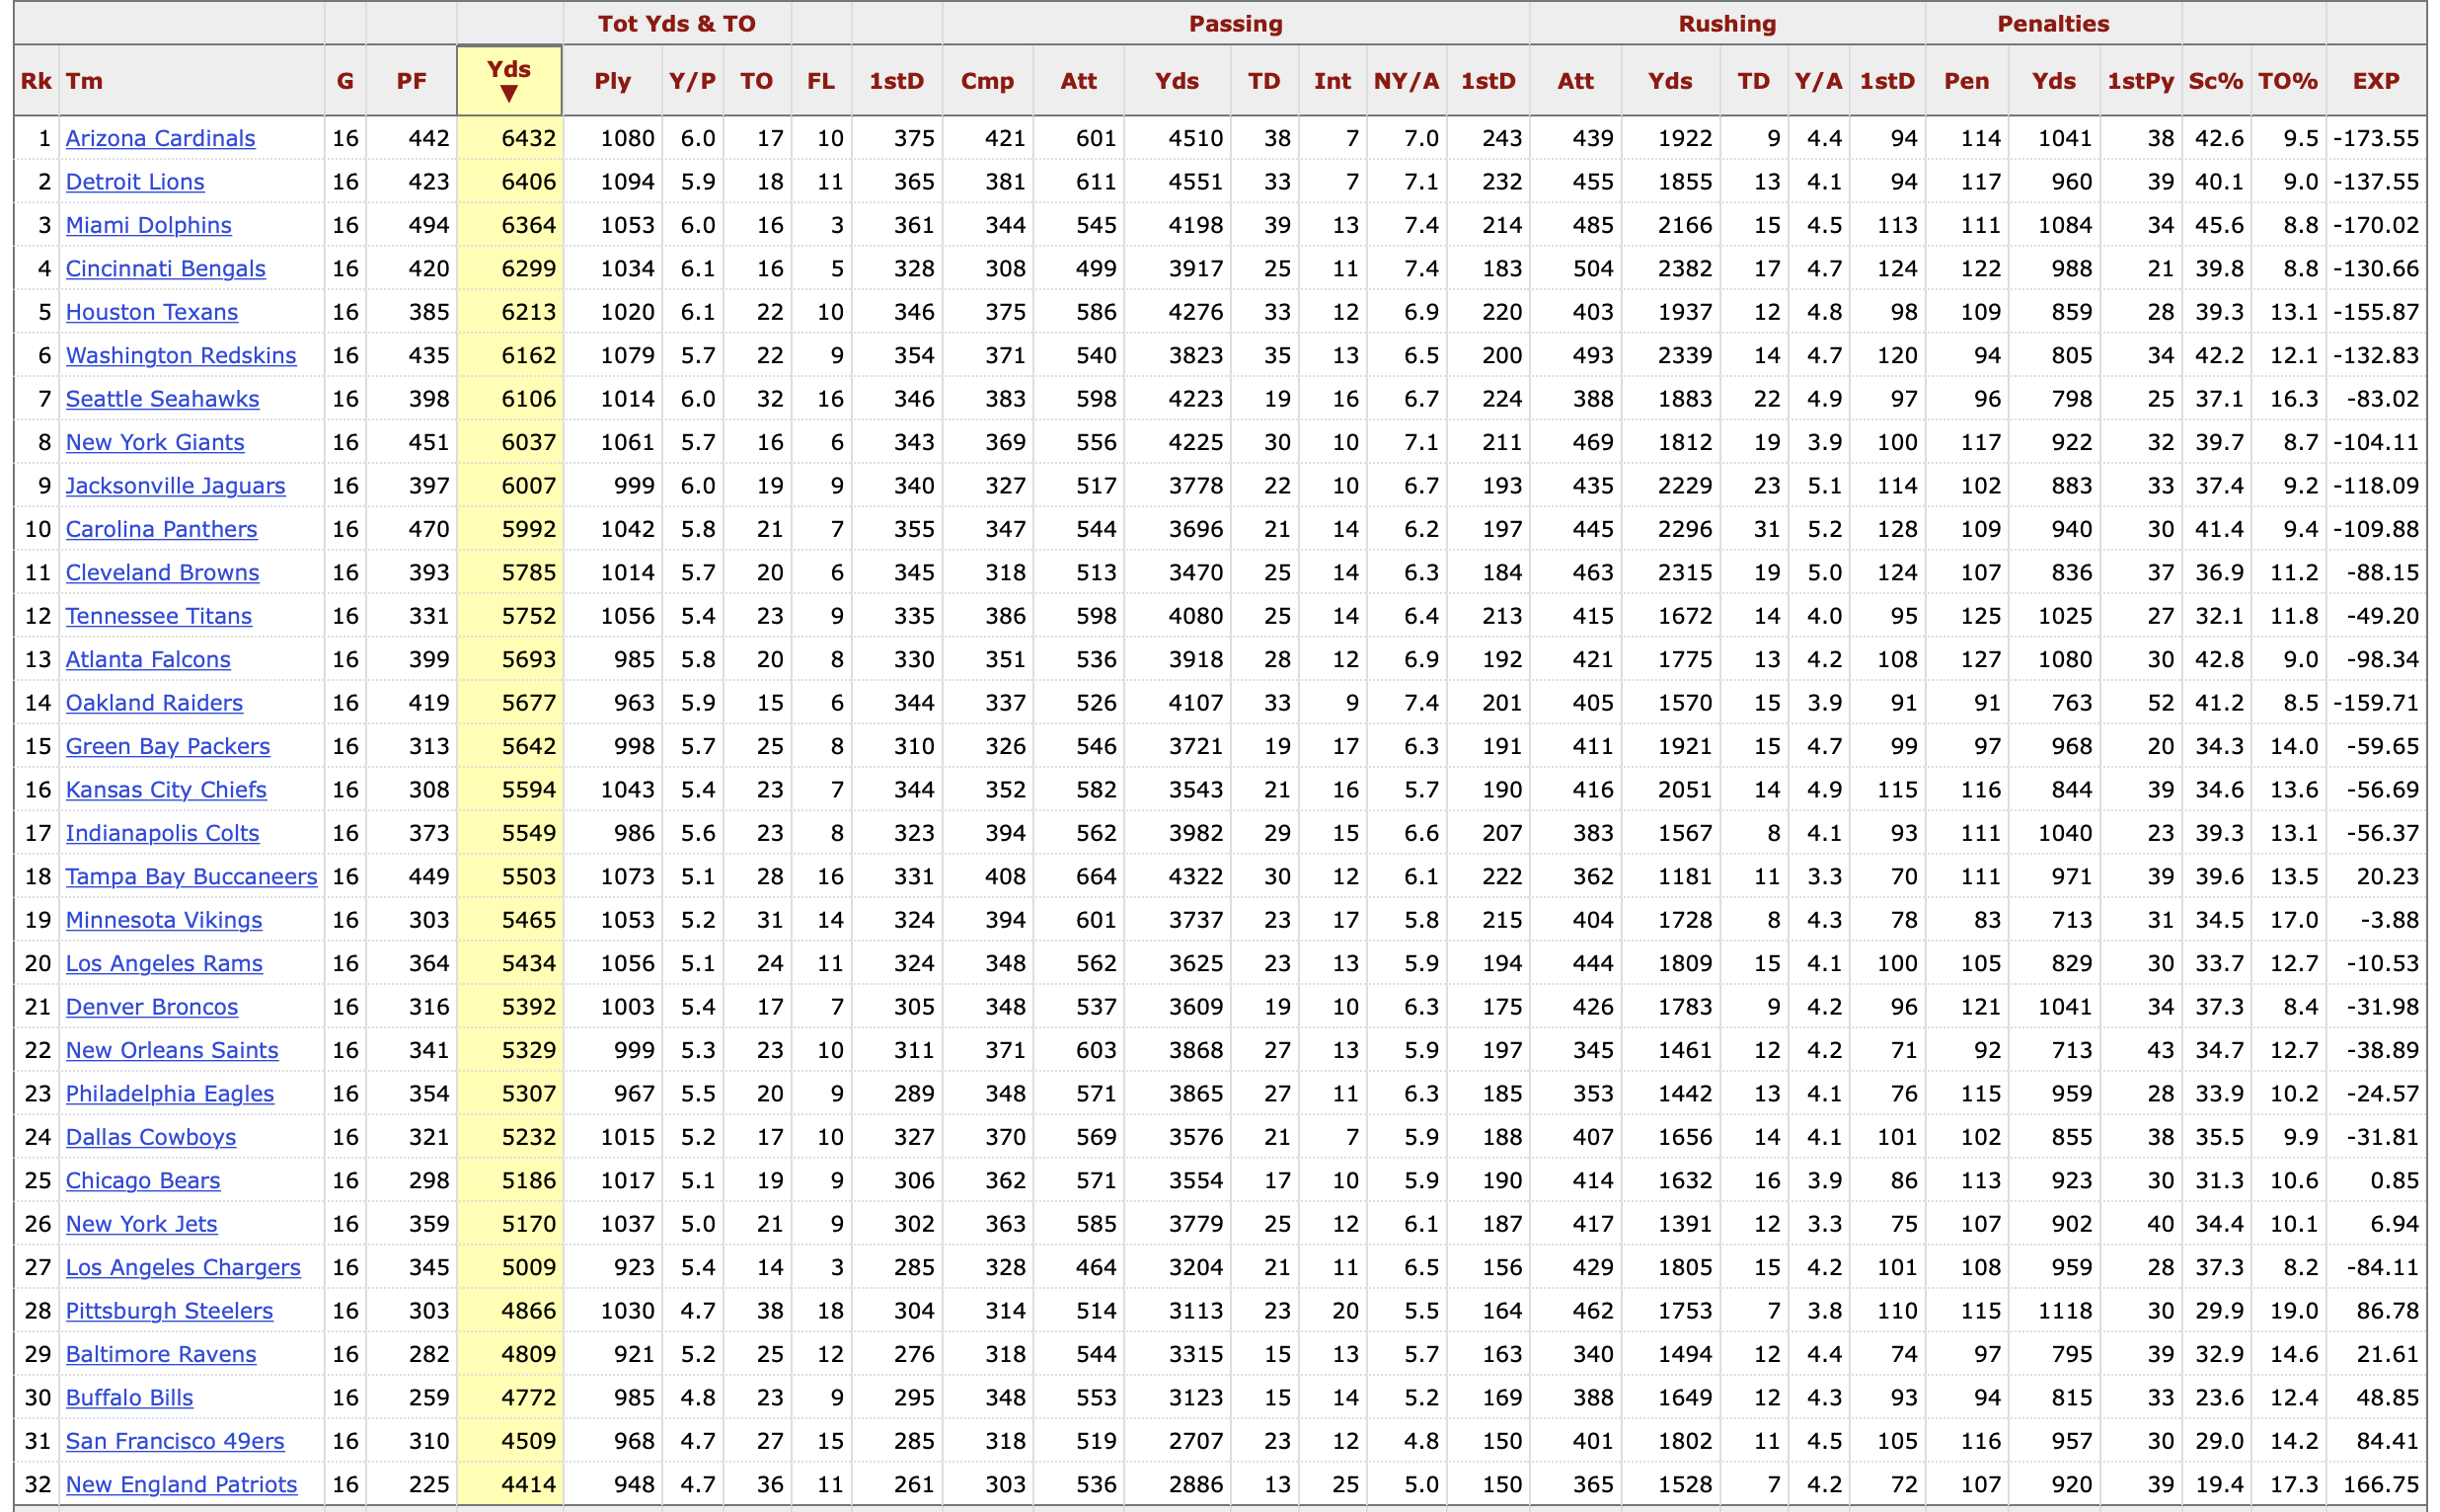

For each season there are about 500-600 different players, each has been given a rank based on their performace in the previous season. The value is a rank 0-4
*   0- Rookie (this is their first NFL seaon)
*   1- Scored less than 100 points in previous season
*   2- Scored between 100-200 points in previous season
*   3- Scored between 200-300 points last season
*   4- Scored more than 300 points last season

Ideally I would have statistics for each player like I did for the teams but since there are hundreds  of players, I did not have the time to do this so the point rankings will have to do.

I realized that it was unrealistic to try and predict a player's exact points with this data and model. So instead the network classifies players into different point classses. Ideally the range of each point class would be 1 but as I said this is unrealistic. For example, if point classes have a range of 10pts, class 0 corresponds to scoring less than 10 points, class 1 corresponds to score 10-20 points, and so on for a total of 5 point classes.


#Benchmarking
To get a benchmark accuracy, I used my dataset with a linear regression model using elastic least squares gradient and momentum. 

In [ ]:
# import the necessary libraries
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import pandas
import math

# increase the width of boxes in the notebook file (this is only cosmetic)
np.set_printoptions(linewidth=180)

In [ ]:
###Linear Regression

class ElasticLeastSquaresGradient:
        
    # fit the model to the data
    def fit(self, X, y, h, tolerance, maxIterations):
        self.n = X.shape[0]
        self.d = X.shape[1]
        
        # save the training data
        self.data = np.hstack((np.ones([self.n, 1]), X))
        
        # save the training labels
        self.outputs = y
       
        # find the beta values that minimize the sum of squared errors via gradient descent
        X = self.data

        # lambda 1 and 2 for ENR 
        L1= 0.1
        L2= 0.1
      
        # lambda function implements elastic net regression
        L = lambda beta: ((X @ beta).T - y.T) @ (X @ beta - y)+ L1*np.sum(np.abs(np.array(beta)))+L2*(np.array(beta).T@np.array(beta))       
        self.beta = self.gradientDescentMomentum(L, (self.d + 1) * [0], h, tolerance, maxIterations)
                
    # predict the output from testing data
    def predict(self, X):
        # initialize an empty matrix to store the predicted outputs
        yPredicted = np.empty([X.shape[0],1])
        
        # append a column of ones at the beginning of X
        X = np.hstack((np.ones([X.shape[0],1]), X))
        
        # apply the function f with the values of beta from the fit function to each testing datapoint (rows of X)
        for row in range(X.shape[0]):
            yPredicted[row] = self.beta @ X[row,]
            
        return yPredicted

    # run gradient descent to minimize the loss function
    def gradientDescentMomentum(self, f, x0, h, tolerance, maxIterations):
        # set x equal to the initial guess
        x = x0
        vdL = np.zeros(len(x))

        B=0.9
      
        # take up to maxIterations number of steps
        for counter in range(maxIterations):
            # update the gradient
            gradient = self.computeGradient(f, x, h)
            if counter%100 == 0:
              print(f'The norm of the gradient at iteration {counter} is {np.linalg.norm(gradient)}')
           
            # stop if the norm of the gradient is near 0
            if np.linalg.norm(gradient) < tolerance:
                print('Gradient descent took', counter, 'iterations to converge')
                print('The norm of the gradient is', np.linalg.norm(gradient))
                # return the approximate critical value x
                return x
            # if we do not converge, print a message
            elif counter == maxIterations-1:
                print("Gradient descent failed")
                print('The gradient is', gradient)
                # return x, sometimes it is still pretty good
                return x

            # take a step in the opposite direction as the gradient
            
            vdL = B*vdL + (1-B)*gradient
            x -= h*vdL
          
    
    # compute the gradient
    def computeGradient(self, f, x, h):
        n = len(x)
        gradient = np.zeros(n)

        for counter in range(n):
            xUp = x.copy()
            xUp[counter] += h
            gradient[counter] = (f(xUp) - f(x))/h

        return gradient

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# import the data from the csv file(s) to an numpy array
path = '2016_2019FantasyData.csv'
data = (pandas.read_csv(path, sep=',').to_numpy())
X = np.array(data[0:,6:33], dtype=float)
y = np.array(data[0:,3], dtype= float)

print(X)
print(y)
y = y.astype('int')

# split the data into training, test, and validation sets
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 2)
(trainX, valX, trainY, valY) = train_test_split(trainX, trainY, test_size=0.25, random_state =1) #0.8*0.25=0.2

# Note that data is scaled
trainX = scale(trainX)
testX = scale(testX)
valX = scale(valX)

print('**** GRADIENT-BASED WITH ELASTIC NET LOSS  \n')
# instantiate an OLS model
model = ElasticLeastSquaresGradient()

# fit the model to the training data (find the beta parameters)
# should use a very small h value 
model.fit(trainX, trainY, h = 0.000001, tolerance = 1, maxIterations = 10000)

# return the predicted outputs for the datapoints in the training set
trainPredictions = model.predict(trainX)

# return the predicted outputs for the datapoints in the test set
predictions = model.predict(testX)

# print the coefficient of determination r^2
print('\nThe r^2 score is', r2_score(trainY, trainPredictions))

# print quality metrics- Training
print('The mean absolute error on the training set is', mean_absolute_error(trainY, trainPredictions))

# print quality metrics- Testing
print('The mean absolute error on the test set is', mean_absolute_error(testY, predictions))

# print quality metrics- Validation 
predictions = model.predict(valX)
print('The mean absolute error on the validation set is', mean_absolute_error(valY, predictions))

for i in range(25):
  if predictions[i] > 1:
    print(f'Predicted: {predictions[i]} \t Real: {valY[i]}')

[[2.70000e+01 2.00000e+00 2.01910e+03 ... 3.90000e+01 3.99000e+01 1.42000e+01]
 [2.30000e+01 3.00000e+00 2.01910e+03 ... 3.80000e+01 4.09000e+01 1.16000e+01]
 [2.70000e+01 1.00000e+00 2.01910e+03 ... 3.90000e+01 3.99000e+01 1.42000e+01]
 ...
 [1.80000e+01 0.00000e+00 2.01617e+03 ... 2.90000e+01 3.79000e+01 6.60000e+00]
 [1.10000e+01 0.00000e+00 2.01617e+03 ... 2.50000e+01 3.23000e+01 1.43000e+01]
 [2.40000e+01 0.00000e+00 2.01617e+03 ... 4.20000e+01 3.74000e+01 7.00000e+00]]
[33.56 33.4   7.1  ...  0.   -2.    0.  ]
**** GRADIENT-BASED WITH ELASTIC NET LOSS  

The norm of the gradient at iteration 0 is 150285.88765628147
The norm of the gradient at iteration 100 is 14161.229158557197
The norm of the gradient at iteration 200 is 1461.4718529186796
The norm of the gradient at iteration 300 is 856.9764533929493
The norm of the gradient at iteration 400 is 677.0511847236583
The norm of the gradient at iteration 500 is 557.9693658037952
The norm of the gradient at iteration 600 is 471.70318

I set the tolerance to 1 gave it a very small step size (h) of 0.000001. After ~8000 iterations, we don't see much improvement and the final r-squared value is 0.142. This is not very good but expected. We can use a fully-conncted feedforward neural network on the dataset and see if we can imporve the accuracy. In order to do this, I have changed the problem from a regression to a classifcation problem using the point classes described in the data section. 

#Feed Forward NN

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# This class is for a fully-connected feedforward neural network using stochastic gradient descent
#
# Inputs:
#
#   layers - a list of numbers of neurons in each layer
#
#   alpha - learning rate
#
#   annealing - a list specifying the annealing schedule for the learning rate
#     'none' - use a constant learning rate
#     ['step', k] - decay the learning rate to 0 at k evenly spaced times with identical steps
#     ['exp', k] - decay the learning rate exponentially alpha = alpha0(exp(-k*epoch))
#     ['inv', k] - decay the learning rate as alpha = alpha0/(1 + k*epoch)
#
#   lambda1 - L1 penalty coefficient (positive)
#
#   lambda2 - L2 penalty coefficient (positive)
#
#   batchSize - size of mini-batches for SGD
#
#   gamma - momentum coefficient (between 0 and 1)
#
#   initialization - a list specifying the initalization
#     ['normal', k] - standard normal random variables divided by k
#     ['uniform', a, b] - uniform random variables between a and b
#     'Nielsen' - standard normal random variables divided by the number of nodes in the next layer
#     ['LeCun', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(3/nodes in previous
#                                        layer) or lower/upper bounds of +/- the same, respectively
#     ['Glorot', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(1/mean of nodes in
#                                         previous and next layers) or lower/upper bounds of +/- the same, respectively
#     ['He', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(6/nodes in previous
#                                     layer) or lower/upper bounds of +/- the same, respectively
#
#   activations - string to choose which activation functions to use:
#     'sigmoid' - sigmoid function
#     'ReLU' - rectified linear unit
#     'ELU' - exponential linear unit
#
#   loss - string to choose which loss function to use:
#     'sum-of-squares'
#     'cross-entropy'

class FeedforwardNeuralNetwork:
    
    def __init__(self, layers, alpha = 0.1, annealing = 'none', lambda1 = 0, lambda2 = 0, batchSize = 32, gamma = 0.0,
                 initialization = 'normal', activations = 'sigmoid', loss = 'sum-of-squares'):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # annealing policy
        self.annealing = annealing
        
        # L1 penalty coefficient
        self.lambda1 = lambda1
        
        # L2 penalty coefficient
        self.lambda2 = lambda2
        
        # batch size
        self.batchSize = batchSize
        
        # momentum parameter
        self.gamma = gamma
        
        # activation type
        self.activation = activations
        
        # loss function
        self.loss = loss
        
        # initialize the weights -- this is our initial guess for gradient descent
        
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        if initialization[0] == 'normal':
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/initialization[1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/initialization[1])
            
        if initialization[0] == 'uniform':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[-2] + 1, layers[-1])))
            
        if initialization == 'Nielsen':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/layers[i+1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/layers[-1])
            
        # LeCun, Glorot, and He initialization
        if initialization[0] in ['LeCun', 'Glorot', 'He']:
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                
                # define the limit term for normal random variables
                
                # LeCun initialization ("efficient backprop", default initialization in PyTorch)
                if initialization[0] == 'LeCun':
                    limit = np.sqrt(1.0 / layers[i+1])
                    
                # Glorot initialization (default initialization in Keras)
                elif initialization[0] == 'Glorot':
                    mean = (layers[i] + layers[i+1])/2.0
                    limit = np.sqrt(1.0 / mean)
                    
                # He initialization (typically used for very deep nets with PReLU activation)
                elif initialization[0] == 'He':
                    limit = np.sqrt(2.0 / layers[i+1])
                
                # generate the weights
                if initialization[1] == 'normal':
                    self.W.append(np.random.normal(0.0, limit, size=(layers[i] + 1, layers[i + 1] + 1)))
                    
                elif initialization[1] == 'uniform':
                    limit *= np.sqrt(3.0)
                    self.W.append(np.random.uniform(-limit, limit, size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)

            # define the limit term for normal random variables
            if initialization[0] == 'LeCun':
                limit = np.sqrt(1.0 / layers[-2])
                
            elif initialization[0] == 'Glorot':
                mean = (layers[-2] + layers[-1])/2.0
                limit = np.sqrt(1.0 / mean)
                    
            elif initialization[0] == 'He':
                limit = np.sqrt(2.0 / layers[-2])
            
            # initialize the weights
            if initialization[1] == 'normal':
                self.W.append(np.random.normal(0.0, limit, size=(layers[-2] + 1, layers[-1])))
                
            elif initialization[1] == 'uniform':
                limit *= np.sqrt(3.0)
                self.W.append(np.random.uniform(-limit, limit, size=(layers[-2] + 1, layers[-1])))
        
    # define the activation function
    def activate(self, x):
        if self.activation == 'sigmoid':
            return 1.0 / (1 + np.exp(-x))

        if self.activation == 'ReLU':
            return x*(x >= 0)
        
        if self.activation == 'ELU':
            return x*(x >= 0) + 0.1*(np.exp(x) - 1)*(x < 0)
    
    # define the activation derivative (where x is the INPUT to activation function)
    def activationDerivative(self, x):
        if self.activation == 'sigmoid':
            return self.activate(x) * (1 - self.activate(x))
        
        if self.activation == 'ReLU':
            return x >= 0
        
        if self.activation == 'ELU':
            return 1*(x >= 0) + 0.1*np.exp(x)*(x < 0)
    
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, valX, valY, epochs = 10000, update = 1000, printPerformance = True):
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))
        losses = []
        trainAccuracies = []
        validationAccuracies = []
        trainY = y
        
        numberOfExamples = X.shape[0]
        
        # use one-hot encoding for the training labels
        y = LabelBinarizer().fit_transform(y)
        
        v = []
        for layer in np.arange(0,len(self.W)):
            v.append(np.zeros(self.W[layer].shape))
            
        alpha = self.alpha

        for epoch in np.arange(0,epochs):
            
            if self.annealing[0] == 'step':
                stepSize = self.alpha/self.annealing[1]
                if epochs > 0 and epoch % self.annealing[1] == 0:
                    alpha -= stepSize
                    print(alpha)
                
            elif self.annealing[0] == 'exp':
                alpha = self.alpha * np.exp(-self.annealing[1] * epoch)
                    
            elif self.annealing[0] == 'inv':
                alpha = self.alpha / (1 + self.annealing[1] * epoch)
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                Z = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    
                    # feed through one layer and apply sigmoid activation
                    net = A[layer].dot(self.W[layer])
                    out = self.activate(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    Z.append(net)
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                
                if self.loss == 'sum-of-squares':
                    D = [error * self.activationDerivative(Z[-1])]
                    
                if self.loss == 'cross-entropy':
                    D = [error]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    delta = delta * self.activationDerivative(Z[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    gradient = (A[layer].T.dot(D[layer])
                                + (self.lambda1 / numberOfExamples) * np.sign(self.W[layer])
                                + (self.lambda2 / numberOfExamples) * self.W[layer])
                    
                    v[layer] = self.gamma * v[layer] + alpha * gradient
                    self.W[layer] -= v[layer]
              
            # print the loss (or maybe more) each 'update' number of epochs
            if (epoch + 1) % update == 0:

                # if we chose, compute the accuracy (this makes it run slower)
                if printPerformance:
                    predictedY = self.predict(valX)
                    predictedY = predictedY.argmax(axis=1)
                    validationAccuracy = accuracy_score(valY, predictedY)           

                    predictedY = self.predict(trainX)
                    predictedY = predictedY.argmax(axis=1)
                    trainAccuracy = accuracy_score(trainY, predictedY)

                    validationAccuracies.append(validationAccuracy)
                    trainAccuracies.append(trainAccuracy)
                    
                    loss = self.computeLoss(X,y)
                    losses.append(loss)
                    print("[INFO] epoch = {}, loss = {:.6f}, training accuracy = {:.6f}, validation accuracy = {:.6f}".format(epoch + 1, loss, trainAccuracy, validationAccuracy))
                    
                # otherwise, simply print the training loss
                else:
                    #losses.append(loss)
                    #print("[INFO] epoch = {}, loss = {:.6f}".format(epoch + 1, loss))
                    print('[INFO] Epoch =', epoch + 1, 'of', epochs)

        # if we chose to print the performance, plot loss, training accuracy, and validation accuracy for each epoch
        if printPerformance:
            fig, ax1 = plt.subplots()

            # plot the losses
            p1 = ax1.plot(np.arange(0, epochs, update), losses, label = 'Loss')
            ax1.set_xlabel('Training Epoch')
            ax1.set_ylabel('Loss')

            # make another y axis using the same x axis
            ax2 = ax1.twinx()
            
            # plot the accuracy
            p2 = ax2.plot(np.arange(0, epochs, update), trainAccuracies, label = 'Accuracy (train)', color = 'tab:orange')
            p3 = ax2.plot(np.arange(0, epochs, update), validationAccuracies, label = 'Accuracy (validation)', color = 'tab:green')
            ax2.set_ylabel('Accuracy')

            # add a legend
            ps = p1 + p2 + p3
            labs = [p.get_label() for p in ps]
            ax1.legend(ps, labs, loc=0)
            
    # feed data into the network and compute the outputs
    def predict(self, X, addOnes = True):
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            p = self.activate(np.dot(p, self.W[layer]))
            
        return p
    
    # compute the loss function
    def computeLoss(self, X, y):
        # initialize data, be sure it's the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = False)
        
        # if the loss function is sum of squares, compute it
        if self.loss == 'sum-of-squares':
            loss = np.sum((predictions - y)**2) / 2.0
            
        # if the loss function is cross-entropy, compute it
        if self.loss == 'cross-entropy':
            loss = np.sum(np.nan_to_num(-y*np.log(predictions)-(1-y)*np.log(1-predictions)))
            
        # if there is an L1 penalty, compute it and add it to the loss
        if self.lambda1 != 0:
            # compute the L1 penalty 
            L1penalty = 0

            for layer in np.arange(0,len(self.W)):
                L1penalty += np.sum(np.abs(self.W[layer]))
        
            # add the L1 penalty to the loss
            loss = loss + (self.lambda1 / X.shape[0]) * L1penalty
            
        # if there is an L2 penalty, compute it and add it to the loss
        if self.lambda2 != 0:
            # compute the L2 penalty 
            L2penalty = 0

            for layer in np.arange(0,len(self.W)):
                L2penalty += np.sum(self.W[layer] ** 2)
        
            # add the L2 penalty to the loss
            loss = loss + (self.lambda2 / X.shape[0]) * L2penalty
        
        return loss

#Training and Testing


[[20 0 1 ... 36 38.2 16.9]
 [3 0 1 ... 33 28.3 10.3]
 [14 0 1 ... 28 32.5 12.9]
 ...
 [17 1 5 ... 33 33.7 8.2]
 [17 1 5 ... 33 33.7 8.2]
 [17 2 5 ... 33 33.7 8.2]]
[0 0 0 ... 0 0 0]
***pointClass Range: 5, Including position infomation


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 10, loss = 26959.319434, training accuracy = 0.531868, validation accuracy = 0.532852
[INFO] epoch = 20, loss = 26847.138256, training accuracy = 0.529459, validation accuracy = 0.533947
[INFO] epoch = 30, loss = 27041.650557, training accuracy = 0.534497, validation accuracy = 0.533290
[INFO] epoch = 40, loss = 26677.659813, training accuracy = 0.537052, validation accuracy = 0.537451
[INFO] epoch = 50, loss = 26824.492952, training accuracy = 0.537782, validation accuracy = 0.528033
[INFO] epoch = 60, loss = 26711.688668, training accuracy = 0.537125, validation accuracy = 0.531537
[INFO] epoch = 70, loss = 26593.487980, training accuracy = 0.538293, validation accuracy = 0.533071
[INFO] epoch = 80, loss = 26397.371519, training accuracy = 0.536176, validation accuracy = 0.536356
[INFO] epoch = 90, loss = 26363.220375, training accuracy = 0.540775, validation accuracy = 0.539860
[INFO] epoch = 100, loss = 26507.717285, training accuracy = 0.542309, validation accuracy 

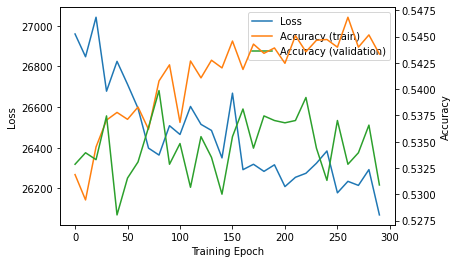

In [ ]:
### ELU activation, Including position info.

from sklearn.metrics import accuracy_score

# import the data from the csv file(s) to an numpy array
path = '2016_2019FantasyData.csv'
data = (pandas.read_csv(path, sep=',').to_numpy())
X = np.array(data[0:,6:33])
y = np.array(data[0:,4])

print(X)
print(y)
y = y.astype('int')


# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1)

# normalize the data`
trainX = normalize(trainX)
testX = normalize(testX)

# scale the data
trainX = scale(trainX)
testX = scale(testX)

#list1 = [0.01, 0.1, 1, 10,100]
#list2 = [0.01, 0.1, 1, 10,100]
# fit the model to the training data 
#for lmbda1 in list1:
print('***pointClass Range: 5, Including position infomation')
model = FeedforwardNeuralNetwork([27, 64, 10], 0.001, 'none', 0.0, 0.0, 32, 0.7, 
                                  ['normal', 100], 'ELU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
#trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
#trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
#testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
#testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

for i in range(10):
    print(f'Predicted pointClass: {predictedY[i]} \t\t Actual pointClass: {testY[i]} ')


Looking at the results, we can see that the loss decreases with more epochs but not significantly enough to see much of an increase in training or testing accuracy. It appears that the model is not learning and more or less just guessing. 

To address this we need to add more data and ideally we can add data that is a significant idicator for fantasy points scored. Here are some ideas to implement:

**1.   Add fields to describle how well the team (not opp. team) performed last season**

For this I used the same source as for the defensive statistics. This added 10 additional fields. 

**2.   Remove fields that do not indicate how many points a player will score.**

  To do this I used the CORREL() function in excel to compute the correlation between points scored and each field in excel. Looking at this list, I removed fields that had a correaltion less than 1%. 

**3.   Add fields to describe how well a player previously**

Clearly playerRank is not enough information so I decided to use the number of points that the player scored last season and if they were a rookie they were given the average points scored that season. 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (46) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[[28 0 1 ... 3.5 -6.1 -3.2]
 [6 0 3 ... 2.1 5.8 0.3]
 [4 1 3 ... -3.9 8.1 6.0]
 ...
 [29 1 5 ... -1.7 -8.8 -3.6]
 [21 0 5 ... 0.7 -0.5 -3.6]
 [7 2 5 ... 0.6 7.0 0.6]]
[0 1 0 ... 0 0 0]
***pointClass Range: 5, Including position infomation


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 10, loss = 27188.113457, training accuracy = 0.534424, validation accuracy = 0.524310
[INFO] epoch = 20, loss = 26849.494546, training accuracy = 0.538366, validation accuracy = 0.524529
[INFO] epoch = 30, loss = 26690.199723, training accuracy = 0.538001, validation accuracy = 0.524310
[INFO] epoch = 40, loss = 26555.691821, training accuracy = 0.542674, validation accuracy = 0.530442
[INFO] epoch = 50, loss = 26503.075035, training accuracy = 0.543404, validation accuracy = 0.526500
[INFO] epoch = 60, loss = 26677.321683, training accuracy = 0.538074, validation accuracy = 0.523872
[INFO] epoch = 70, loss = 26537.612081, training accuracy = 0.539169, validation accuracy = 0.522996
[INFO] epoch = 80, loss = 26456.160166, training accuracy = 0.542747, validation accuracy = 0.524748
[INFO] epoch = 90, loss = 26463.932258, training accuracy = 0.540556, validation accuracy = 0.528909
[INFO] epoch = 100, loss = 26358.182148, training accuracy = 0.543039, validation accuracy 

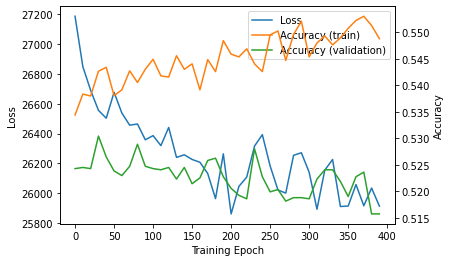

In [ ]:
### 1. Including Team info.

from sklearn.metrics import accuracy_score

# import the data from the csv file(s) to an numpy array
path = '2016_2019FantasyData.csv'
data = (pandas.read_csv(path, sep=',').to_numpy())
X = np.array(data[0:,6:44])
y = np.array(data[0:,4])

print(X)
print(y)
y = y.astype('int')


# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1)

# normalize the data`
trainX = normalize(trainX)
testX = normalize(testX)

# scale the data
trainX = scale(trainX)
testX = scale(testX)

# fit the model to the training data 
print('***pointClass Range: 5, Including position infomation')
model = FeedforwardNeuralNetwork([38, 64, 10], 0.001, 'none', 1, 100, 32, 0.7, 
                                  ['normal', 100], 'ELU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 400, 10)

print("Training set accuracy")
#trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
#trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
#testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
#testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

for i in range(30):
  if testY[i] != 0:
    print(f'Predicted pointClass: {predictedY[i]} \t\t Actual pointClass: {testY[i]} ')


Adding these additional fields gave us a little bit of an improvement. Next I will remove the fields that have a less than 1% correlation. I am hoping that even though this decreases the ammount of data, it will increases the overall significance of the data and in turn increase the accuracy or at least help the network learn. I ended up removing 5 fields from the data so at the very least, training should be faster.

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[[28 0 1 ... -9.6 3.5 -6.1]
 [6 0 3 ... 3.7 2.1 5.8]
 [4 1 3 ... 12.0 -3.9 8.1]
 ...
 [29 1 5 ... -7.1 -1.7 -8.8]
 [21 0 5 ... -1.3 0.7 -0.5]
 [7 2 5 ... 6.4 0.6 7.0]]
[0 1 0 ... 0 0 0]
***pointClass Range: 5, Including team infomation


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 10, loss = 27264.466237, training accuracy = 0.534570, validation accuracy = 0.524091
[INFO] epoch = 20, loss = 26866.081300, training accuracy = 0.536687, validation accuracy = 0.526062
[INFO] epoch = 30, loss = 26662.413011, training accuracy = 0.539315, validation accuracy = 0.522996
[INFO] epoch = 40, loss = 26704.336816, training accuracy = 0.536322, validation accuracy = 0.523215
[INFO] epoch = 50, loss = 26817.727953, training accuracy = 0.541724, validation accuracy = 0.522339
[INFO] epoch = 60, loss = 26434.880179, training accuracy = 0.538658, validation accuracy = 0.524529
[INFO] epoch = 70, loss = 26672.895578, training accuracy = 0.538877, validation accuracy = 0.524091
[INFO] epoch = 80, loss = 26413.733937, training accuracy = 0.542747, validation accuracy = 0.524091
[INFO] epoch = 90, loss = 26552.300587, training accuracy = 0.540191, validation accuracy = 0.524091
[INFO] epoch = 100, loss = 26560.041366, training accuracy = 0.542528, validation accuracy 

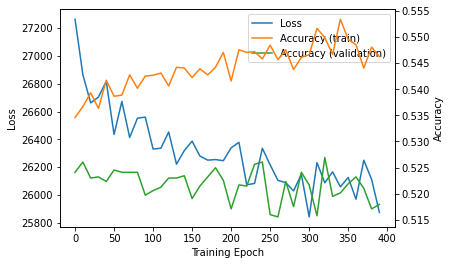

In [ ]:
### 1. Removing insignificant fields

from sklearn.metrics import accuracy_score

# import the data from the csv file(s) to an numpy array
path = '2016_2019FantasyData.csv'
data = (pandas.read_csv(path, sep=',').to_numpy())
X = np.array(data[0:,6:39])
y = np.array(data[0:,4])

print(X)
print(y)
y = y.astype('int')


# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1)

# normalize the data`
trainX = normalize(trainX)
testX = normalize(testX)

# scale the data
trainX = scale(trainX)
testX = scale(testX)

# fit the model to the training data 
print('***pointClass Range: 5, Including team infomation')
model = FeedforwardNeuralNetwork([33, 64, 10], 0.001, 'none', 1, 100, 32, 0.7, 
                                  ['normal', 100], 'ELU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 400, 10)

print("Training set accuracy")
#trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
#trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
#testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
#testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

for i in range(30):
  if testY[i] != 0:
    print(f'Predicted pointClass: {predictedY[i]} \t\t Actual pointClass: {testY[i]} ')


It looks like this didn't help too much but it may have made some difference, or perhaps on a larger scale this would have had more impact. Note that the model places a player in class zero far too often, this is a big concern and without a lot more data, I don't think this will change much.

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[[28 0 1 ... -9.6 3.5 -6.1]
 [6 0 3 ... 3.7 2.1 5.8]
 [4 1 3 ... 12.0 -3.9 8.1]
 ...
 [29 1 5 ... -7.1 -1.7 -8.8]
 [21 0 5 ... -1.3 0.7 -0.5]
 [7 2 5 ... 6.4 0.6 7.0]]
[0 1 0 ... 0 0 0]
***Weight Initialziation: He, normal


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 10, loss = 26731.465557, training accuracy = 0.537271, validation accuracy = 0.521682
[INFO] epoch = 20, loss = 26583.270040, training accuracy = 0.542236, validation accuracy = 0.523434
[INFO] epoch = 30, loss = 26371.931550, training accuracy = 0.545959, validation accuracy = 0.523215
[INFO] epoch = 40, loss = 26372.280905, training accuracy = 0.545521, validation accuracy = 0.523434
[INFO] epoch = 50, loss = 26375.966112, training accuracy = 0.546981, validation accuracy = 0.523872
[INFO] epoch = 60, loss = 26381.071611, training accuracy = 0.543404, validation accuracy = 0.524748
[INFO] epoch = 70, loss = 26104.638065, training accuracy = 0.545156, validation accuracy = 0.522996
[INFO] epoch = 80, loss = 26213.636827, training accuracy = 0.548003, validation accuracy = 0.524310
[INFO] epoch = 90, loss = 26368.400253, training accuracy = 0.545521, validation accuracy = 0.519930
[INFO] epoch = 100, loss = 26012.774313, training accuracy = 0.546835, validation accuracy 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 10, loss = 26774.739181, training accuracy = 0.536468, validation accuracy = 0.524310
[INFO] epoch = 20, loss = 26483.251905, training accuracy = 0.536614, validation accuracy = 0.525186
[INFO] epoch = 30, loss = 26424.729261, training accuracy = 0.542747, validation accuracy = 0.523215
[INFO] epoch = 40, loss = 26727.569565, training accuracy = 0.544791, validation accuracy = 0.526500
[INFO] epoch = 50, loss = 26287.049704, training accuracy = 0.544937, validation accuracy = 0.523653
[INFO] epoch = 60, loss = 26254.661973, training accuracy = 0.546105, validation accuracy = 0.523653
[INFO] epoch = 70, loss = 26366.562156, training accuracy = 0.545156, validation accuracy = 0.527157
[INFO] epoch = 80, loss = 26168.542074, training accuracy = 0.548441, validation accuracy = 0.527814
[INFO] epoch = 90, loss = 26402.506994, training accuracy = 0.547784, validation accuracy = 0.524529
[INFO] epoch = 100, loss = 26152.557300, training accuracy = 0.549755, validation accuracy 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 10, loss = 26839.867513, training accuracy = 0.540118, validation accuracy = 0.526719
[INFO] epoch = 20, loss = 26375.952503, training accuracy = 0.536614, validation accuracy = 0.522777
[INFO] epoch = 30, loss = 26597.927200, training accuracy = 0.540994, validation accuracy = 0.526281
[INFO] epoch = 40, loss = 26216.022801, training accuracy = 0.542528, validation accuracy = 0.522996
[INFO] epoch = 50, loss = 26260.347376, training accuracy = 0.542382, validation accuracy = 0.523653
[INFO] epoch = 60, loss = 26398.029756, training accuracy = 0.542747, validation accuracy = 0.520806
[INFO] epoch = 70, loss = 26216.784288, training accuracy = 0.547200, validation accuracy = 0.523872
[INFO] epoch = 80, loss = 26257.284743, training accuracy = 0.543623, validation accuracy = 0.521682
[INFO] epoch = 90, loss = 26093.754216, training accuracy = 0.547565, validation accuracy = 0.524091
[INFO] epoch = 100, loss = 26099.402319, training accuracy = 0.548660, validation accuracy 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 10, loss = 26600.340412, training accuracy = 0.537636, validation accuracy = 0.521244
[INFO] epoch = 20, loss = 26511.881698, training accuracy = 0.541140, validation accuracy = 0.523653
[INFO] epoch = 30, loss = 26691.077938, training accuracy = 0.541140, validation accuracy = 0.522777
[INFO] epoch = 40, loss = 26385.718771, training accuracy = 0.544499, validation accuracy = 0.525405
[INFO] epoch = 50, loss = 26238.961125, training accuracy = 0.542163, validation accuracy = 0.519054
[INFO] epoch = 60, loss = 26374.770019, training accuracy = 0.543331, validation accuracy = 0.518178
[INFO] epoch = 70, loss = 26340.134583, training accuracy = 0.546324, validation accuracy = 0.524091
[INFO] epoch = 80, loss = 26090.385241, training accuracy = 0.546908, validation accuracy = 0.524529
[INFO] epoch = 90, loss = 26082.847448, training accuracy = 0.548806, validation accuracy = 0.518397
[INFO] epoch = 100, loss = 26218.867763, training accuracy = 0.547346, validation accuracy 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 10, loss = 26505.947798, training accuracy = 0.540775, validation accuracy = 0.523215
[INFO] epoch = 20, loss = 26706.881490, training accuracy = 0.540264, validation accuracy = 0.529128
[INFO] epoch = 30, loss = 26413.945233, training accuracy = 0.542016, validation accuracy = 0.523215
[INFO] epoch = 40, loss = 26463.764897, training accuracy = 0.545010, validation accuracy = 0.526062
[INFO] epoch = 50, loss = 26427.714329, training accuracy = 0.539534, validation accuracy = 0.521682
[INFO] epoch = 60, loss = 26297.059275, training accuracy = 0.545886, validation accuracy = 0.515331
[INFO] epoch = 70, loss = 26194.754818, training accuracy = 0.545521, validation accuracy = 0.517083
[INFO] epoch = 80, loss = 26175.889072, training accuracy = 0.542966, validation accuracy = 0.522339
[INFO] epoch = 90, loss = 26210.091107, training accuracy = 0.544499, validation accuracy = 0.520587
[INFO] epoch = 100, loss = 26099.824814, training accuracy = 0.547857, validation accuracy 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 10, loss = 26921.952243, training accuracy = 0.537125, validation accuracy = 0.523434
[INFO] epoch = 20, loss = 26688.263368, training accuracy = 0.540045, validation accuracy = 0.521244
[INFO] epoch = 30, loss = 26588.333122, training accuracy = 0.539023, validation accuracy = 0.526500
[INFO] epoch = 40, loss = 26370.608426, training accuracy = 0.540556, validation accuracy = 0.523434
[INFO] epoch = 50, loss = 26360.717980, training accuracy = 0.543769, validation accuracy = 0.526719
[INFO] epoch = 60, loss = 26322.881343, training accuracy = 0.545083, validation accuracy = 0.522777
[INFO] epoch = 70, loss = 26259.312681, training accuracy = 0.547857, validation accuracy = 0.524748
[INFO] epoch = 80, loss = 26287.271937, training accuracy = 0.548879, validation accuracy = 0.520149
[INFO] epoch = 90, loss = 26293.256795, training accuracy = 0.544499, validation accuracy = 0.526500
[INFO] epoch = 100, loss = 26288.935492, training accuracy = 0.545521, validation accuracy 

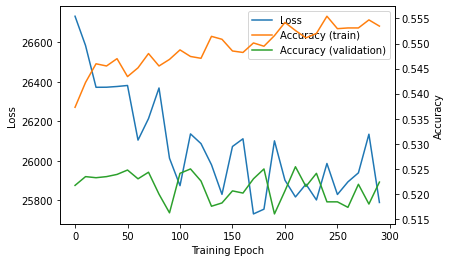

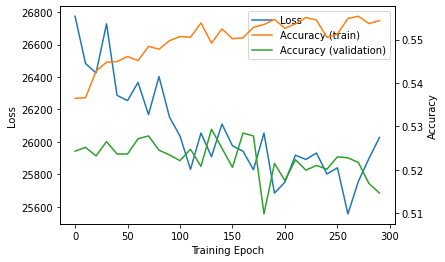

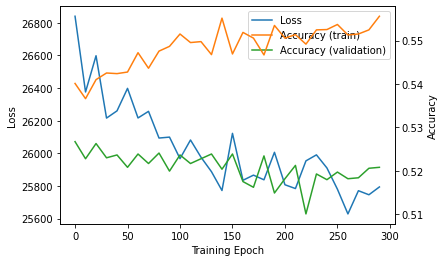

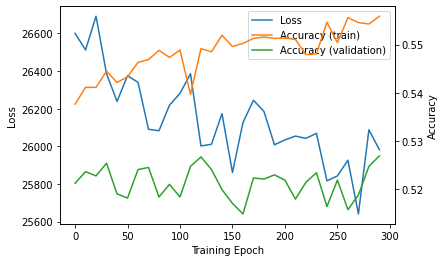

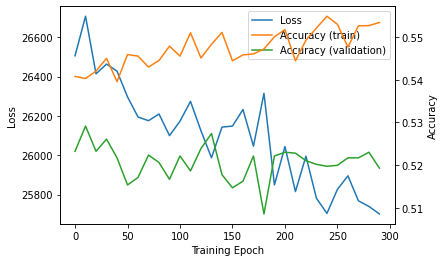

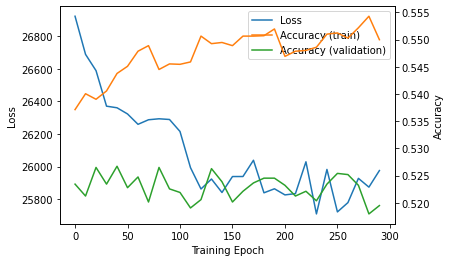

In [ ]:
### Hyperparameter tuning
## Weight Initializations

from sklearn.metrics import accuracy_score

# import the data from the csv file(s) to an numpy array
path = '2016_2019FantasyData.csv'
data = (pandas.read_csv(path, sep=',').to_numpy())
X = np.array(data[0:,6:39])
y = np.array(data[0:,4])

print(X)
print(y)
y = y.astype('int')


# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1)

# normalize the data`
trainX = normalize(trainX)
testX = normalize(testX)

# scale the data
trainX = scale(trainX)
testX = scale(testX)
list = ['He', 'Glorot', 'LeCun']
list2= ['normal', 'uniform']
for method in list:
  for dist in list2:
    # fit the model to the training data 
    print(f'***Weight Initialziation: {method}, {dist}')
    model = FeedforwardNeuralNetwork([33, 64, 10], 0.001, 'none', 0, 100, 32, 0.7, 
                                      [method, dist], 'ELU', 'cross-entropy')
    model.fit(trainX, trainY, testX, testY, 300, 10)

    print("Training set accuracy")
    #trainY = LabelBinarizer().fit_transform(trainY)
    predictedY = model.predict(trainX)
    predictedY = predictedY.argmax(axis=1)
    #trainY = trainY.argmax(axis=1)
    print(accuracy_score(trainY, predictedY))

    print("Test set accuracy")
    #testY = LabelBinarizer().fit_transform(testY)
    predictedY = model.predict(testX)
    predictedY = predictedY.argmax(axis=1)
    #testY = testY.argmax(axis=1)
    print(accuracy_score(testY, predictedY))



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[[28 0 1 ... -9.6 3.5 -6.1]
 [6 0 3 ... 3.7 2.1 5.8]
 [4 1 3 ... 12.0 -3.9 8.1]
 ...
 [29 1 5 ... -7.1 -1.7 -8.8]
 [21 0 5 ... -1.3 0.7 -0.5]
 [7 2 5 ... 6.4 0.6 7.0]]
[0 1 0 ... 0 0 0]
***Layers: [33, 64, 10]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 10, loss = 26590.554323, training accuracy = 0.538001, validation accuracy = 0.519711
[INFO] epoch = 20, loss = 26388.389548, training accuracy = 0.539315, validation accuracy = 0.526062
[INFO] epoch = 30, loss = 26458.159834, training accuracy = 0.544134, validation accuracy = 0.525186
[INFO] epoch = 40, loss = 26463.231331, training accuracy = 0.545010, validation accuracy = 0.516864
[INFO] epoch = 50, loss = 26271.523319, training accuracy = 0.544791, validation accuracy = 0.526062
[INFO] epoch = 60, loss = 26229.635768, training accuracy = 0.546397, validation accuracy = 0.521901
[INFO] epoch = 70, loss = 26151.943354, training accuracy = 0.547492, validation accuracy = 0.527376
[INFO] epoch = 80, loss = 26115.594012, training accuracy = 0.547711, validation accuracy = 0.526938
[INFO] epoch = 90, loss = 26547.815760, training accuracy = 0.542236, validation accuracy = 0.512922
[INFO] epoch = 100, loss = 26079.535128, training accuracy = 0.548952, validation accuracy 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 10, loss = 26434.326486, training accuracy = 0.543185, validation accuracy = 0.526500
[INFO] epoch = 20, loss = 26344.731620, training accuracy = 0.541286, validation accuracy = 0.521463
[INFO] epoch = 30, loss = 26126.956549, training accuracy = 0.542893, validation accuracy = 0.518835
[INFO] epoch = 40, loss = 25965.958693, training accuracy = 0.547346, validation accuracy = 0.525405
[INFO] epoch = 50, loss = 25853.802361, training accuracy = 0.548587, validation accuracy = 0.519054
[INFO] epoch = 60, loss = 25835.318948, training accuracy = 0.550339, validation accuracy = 0.522120
[INFO] epoch = 70, loss = 25885.178454, training accuracy = 0.550339, validation accuracy = 0.519054
[INFO] epoch = 80, loss = 25998.239937, training accuracy = 0.550339, validation accuracy = 0.519711
[INFO] epoch = 90, loss = 25770.402627, training accuracy = 0.556399, validation accuracy = 0.518397
[INFO] epoch = 100, loss = 25614.758883, training accuracy = 0.554647, validation accuracy 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 10, loss = 26691.131291, training accuracy = 0.538147, validation accuracy = 0.523872
[INFO] epoch = 20, loss = 26223.210563, training accuracy = 0.544645, validation accuracy = 0.530880
[INFO] epoch = 30, loss = 26155.414738, training accuracy = 0.546470, validation accuracy = 0.525186
[INFO] epoch = 40, loss = 25717.640427, training accuracy = 0.554355, validation accuracy = 0.525843
[INFO] epoch = 50, loss = 25702.914072, training accuracy = 0.554209, validation accuracy = 0.522339
[INFO] epoch = 60, loss = 25469.590529, training accuracy = 0.561875, validation accuracy = 0.521682
[INFO] epoch = 70, loss = 25175.130125, training accuracy = 0.561437, validation accuracy = 0.521025
[INFO] epoch = 80, loss = 24973.353581, training accuracy = 0.570855, validation accuracy = 0.513798
[INFO] epoch = 90, loss = 25014.345824, training accuracy = 0.576769, validation accuracy = 0.511608
[INFO] epoch = 100, loss = 25072.979560, training accuracy = 0.573921, validation accuracy 

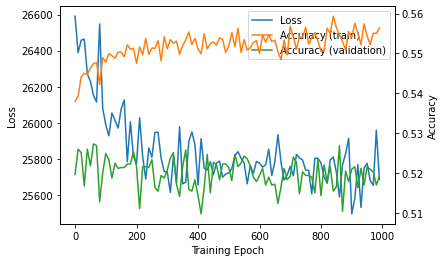

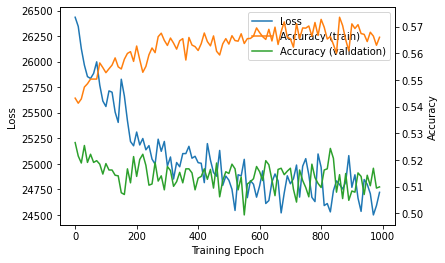

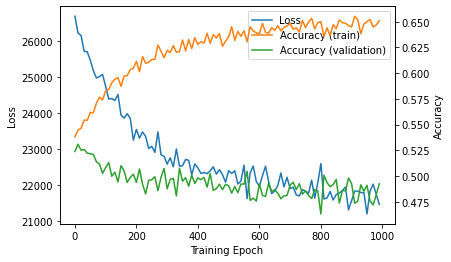

In [ ]:
### Testing
## Differnt Layers
## More epochs

from sklearn.metrics import accuracy_score

# import the data from the csv file(s) to an numpy array
path = '2016_2019FantasyData.csv'
data = (pandas.read_csv(path, sep=',').to_numpy())
X = np.array(data[0:,6:39])
y = np.array(data[0:,4])

print(X)
print(y)
y = y.astype('int')


# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1)

# normalize the data`
trainX = normalize(trainX)
testX = normalize(testX)

# scale the data
trainX = scale(trainX)
testX = scale(testX)

list = [[33,64,10],[33,128,10],[33,128,32,10]]
for combo in list:
  # fit the model to the training data 
  print(f'***Layers: {combo}')
  model = FeedforwardNeuralNetwork(combo, 0.001, 'none', 1, 100, 32, 0.7, 
                                    ['Glorot', 'normal'], 'ELU', 'cross-entropy')
  model.fit(trainX, trainY, testX, testY, 1000, 10)

  print("Training set accuracy")
  #trainY = LabelBinarizer().fit_transform(trainY)
  predictedY = model.predict(trainX)
  predictedY = predictedY.argmax(axis=1)
  #trainY = trainY.argmax(axis=1)
  print(accuracy_score(trainY, predictedY))

  print("Test set accuracy")
  #testY = LabelBinarizer().fit_transform(testY)
  predictedY = model.predict(testX)
  predictedY = predictedY.argmax(axis=1)
  #testY = testY.argmax(axis=1)
  print(accuracy_score(testY, predictedY))



Adding an additional layer actually gave an interesting result, the training accuracy was significantly higher but the testing accuracy decreased. It seems that the additional layer only caused the model to overfit to the training data. 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[[28 0 1 ... -9.6 3.5 -6.1]
 [6 0 3 ... 3.7 2.1 5.8]
 [4 1 3 ... 12.0 -3.9 8.1]
 ...
 [29 1 5 ... -7.1 -1.7 -8.8]
 [21 0 5 ... -1.3 0.7 -0.5]
 [7 2 5 ... 6.4 0.6 7.0]]
[0 1 0 ... 0 0 0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:342: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 10, loss = 26729.057448, training accuracy = 0.538001, validation accuracy = 0.524091
[INFO] epoch = 20, loss = 26586.991252, training accuracy = 0.539023, validation accuracy = 0.526938
[INFO] epoch = 30, loss = 26591.873070, training accuracy = 0.535081, validation accuracy = 0.522996
[INFO] epoch = 40, loss = 26542.751582, training accuracy = 0.542966, validation accuracy = 0.525624
[INFO] epoch = 50, loss = 26432.016355, training accuracy = 0.543550, validation accuracy = 0.523653
[INFO] epoch = 60, loss = 26204.622324, training accuracy = 0.544061, validation accuracy = 0.521901
[INFO] epoch = 70, loss = 26289.555761, training accuracy = 0.547565, validation accuracy = 0.524091
[INFO] epoch = 80, loss = 26331.199699, training accuracy = 0.545740, validation accuracy = 0.522777
[INFO] epoch = 90, loss = 26211.350263, training accuracy = 0.546324, validation accuracy = 0.522120
[INFO] epoch = 100, loss = 26187.247525, training accuracy = 0.549682, validation accuracy 

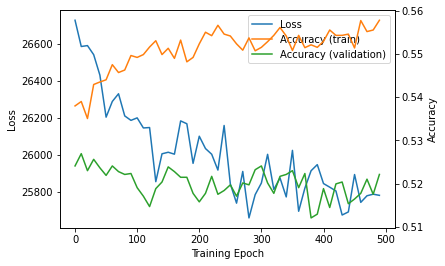

In [ ]:
### Testing
## Differnt Layers
## More epochs

from sklearn.metrics import accuracy_score

# import the data from the csv file(s) to an numpy array
path = '2016_2019FantasyData.csv'
data = (pandas.read_csv(path, sep=',').to_numpy())
X = np.array(data[0:,6:39])
y = np.array(data[0:,4])

print(X)
print(y)
y = y.astype('int')


# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1)

# normalize the data`
trainX = normalize(trainX)
testX = normalize(testX)

# scale the data
trainX = scale(trainX)
testX = scale(testX)

# fit the model to the training data 
model = FeedforwardNeuralNetwork([33,64,10], 0.001, 'none', 1, 100, 32, 0.7, 
                                  ['Glorot', 'uniform'], 'ELU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 500, 10)

print("Training set accuracy")
#trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
#trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
#testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
#testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))


#Closing Thoughts
The model is not learning well because there are not enough indicators for it to learn from. The points earned by a player in a game is influenced by so many things that it is close to random. For example, players tend to perform worse in rainy weather, but only if the stadium has an open roof. Due to these complex indicators, without a lot more data it will be hard to get an accurate prediction. Adding player statistics could bring a big improvement to the model but will require a lot of manual data entry and was not feasible in the time frame of the project. Additioinally, including data for the current season (rather than using the previous season data) could bring good inprovements, but again this data is hard to gather manually. I would like to work on some web scraping methods to pull relevant information from various sources on the Internet and see if a better data set can be compiled. 